這個比賽是一個分兩類的比賽，似乎定期會推出不同的比賽
連結:https://www.kaggle.com/competitions/playground-series-s3e12
選擇此比賽原因最主要是因為該比賽的資料集已經經過初步結構化，對第一次參加比賽的我比較友善，且欄位、features也比較少。
針對此資料集，包含ID共有8個欄位，而有一個欄位就是判斷的目標，其餘的欄位也都是以數字組成的欄位，最主要集是要判對各個ID的target該是甚麼。

以下就是我的實作程式碼，不過在這裡先簡述我的思路及我的實作與上課的關聯，甚至我延伸學習了甚麼:
首先老師在課堂中帶我們走了分類問題的其中一個基本模型--logisticregression，並教我們如和建模、將模型套用在資料及上，以及切分資料集，這些我在這次實作中都有應用到。但另一方面，我還想知道，藉由這次機會，是否能比較一些大家都常用來分類的模型來比較看看到底哪個模型最準。於是我最終選擇了logisticregression, decision tree, random forest, KNN, svm共五個模型進行比較，在沒調整參數的情況下比較出結果後，我認為參數的調整也是影響模型表現得很大一個因素。因此我將表現最好的模型選出來，利用sklearn的grid search找最佳參數，結果順利提升了一些準確度。
最終的結果以及反思則寫在coding後面

In [2]:
#先載入會使用到的資料庫
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib as plt



In [3]:
#將training 資料導入並定義df
df = pd.read_csv("C:\\Users\\rick\\AI code\\midterm\\train.csv")

In [4]:
#觀察資料的架構
df.head()
df.describe().T

,count,mean,std,min,25%,50%,75%,max
id,414.0,206.500000,119.655756,0.000,103.250,206.500,309.750,413.00
gravity,414.0,1.017894,0.006675,1.005,1.012,1.018,1.022,1.04
ph,414.0,5.955459,0.642260,4.760,5.530,5.740,6.280,7.94
osmo,414.0,651.545894,234.676567,187.000,455.250,679.500,840.000,1236.00
cond,414.0,21.437923,7.514750,5.100,15.500,22.200,27.600,38.00
urea,414.0,278.657005,136.442249,10.000,170.000,277.000,385.000,620.00
calc,414.0,4.114638,3.217641,0.170,1.450,3.130,6.630,14.34
target,414.0,0.444444,0.497505,0.000,0.000,0.000,1.000,1.00


In [7]:
#查看資料有無缺失值，並得知每個欄位的資料type(可發現此資料已經過初步結構化)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 414 entries, 0 to 413
Data columns (total 8 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   id       414 non-null    int64  
 1   gravity  414 non-null    float64
 2   ph       414 non-null    float64
 3   osmo     414 non-null    int64  
 4   cond     414 non-null    float64
 5   urea     414 non-null    int64  
 6   calc     414 non-null    float64
 7   target   414 non-null    int64  
dtypes: float64(4), int64(4)
memory usage: 26.0 KB


In [9]:
#利用此行程式確認資料是否為imbalanced data(結果顯示還算平衡)
#若結果為imbalanced data 可能要用oversampling 或 undersampling的方式去平衡資料
df['target'].value_counts()

0    230
1    184
Name: target, dtype: int64

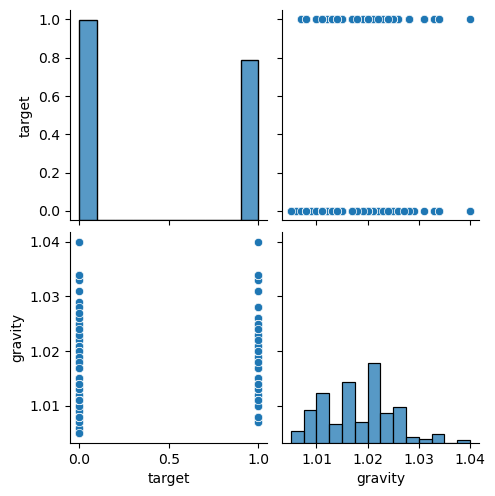

In [10]:
#在這張圖中能發現gravity越接近平均值被判為一個機率更高
sns.pairplot(df[['target','gravity']],dropna=True)

In [11]:
#觀察各欄資料與target欄位的關聯，發現calc欄位與target欄位可能最有關係
df.groupby('target').mean()
df.corr()

,id,gravity,ph,osmo,cond,urea,calc,target
id,1.000000,-0.004775,-0.086619,0.008030,0.032843,-0.023822,0.032360,0.018222
gravity,-0.004775,1.000000,-0.290349,0.692317,0.470433,0.631710,0.494304,0.282577
ph,-0.086619,-0.290349,1.000000,-0.309495,-0.190185,-0.279749,-0.214402,-0.094983
osmo,0.008030,0.692317,-0.309495,1.000000,0.708480,0.809880,0.472114,0.244770
cond,0.032843,0.470433,-0.190185,0.708480,1.000000,0.499109,0.330609,0.172224
urea,-0.023822,0.631710,-0.279749,0.809880,0.499109,1.000000,0.489879,0.265211
calc,0.032360,0.494304,-0.214402,0.472114,0.330609,0.489879,1.000000,0.467439
target,0.018222,0.282577,-0.094983,0.244770,0.172224,0.265211,0.467439,1.000000


In [12]:
'''
藉由剛剛的程式已能知曉此資料集無須補空值。
而共只有五欄能用來分類，故全部欄位都會拿來預測結果。

'''

'\n藉由剛剛的程式已能知曉此資料集無須補空值。\n而共只有五欄能用來分類，故全部欄位都會拿來預測結果。\n\n'

In [13]:
#創立模型的訓練集及測試集
#dx 就是將要分類的target去除後剩餘的其他欄位，dy則是要分類的目標
dx = df.drop(['target'], axis = 1)
dy = df['target']
print(dx.head())
print(dy.head())

   id  gravity    ph  osmo  cond  urea  calc
0   0    1.013  6.19   443  14.8   124  1.45
1   1    1.025  5.40   703  23.6   394  4.18
2   2    1.009  6.13   371  24.5   159  9.04
3   3    1.021  4.91   442  20.8   398  6.63
4   4    1.021  5.53   874  17.8   385  2.21
0    0
1    0
2    0
3    1
4    1
Name: target, dtype: int64


In [14]:
#導入要使用的切分library，30%當測試集，且使用statify讓兩類資料在測試集平衡
from sklearn.model_selection import train_test_split
dx_train, dx_test, dy_train, dy_test = train_test_split(dx, dy, test_size = 0.3, random_state = 42,stratify = dy)

In [15]:
#載入第一個model(logisticregression)
from sklearn.linear_model import LogisticRegression
#定義模型
lr = LogisticRegression()
#將訓練集放入模型裡測試
lr.fit(dx_train, dy_train)
#讓訓練後的模型去分類測試集
predictions_lr=lr.predict(dx_test)
#載入能評價模型預測結果的matrix
from sklearn.metrics import confusion_matrix,accuracy_score, recall_score, precision_score

In [16]:
#因資料集沒有不平等的問題，故等等主要還是使用準確度與其他模型對比
accuracy_score(dy_test,predictions_lr) 
recall_score(dy_test, predictions_lr) #怕Type II Error的，可使用此評價
precision_score(dy_test, predictions_lr) #怕Type I Error的，可使用此評價
#畫出confusion matrix
pd.DataFrame(confusion_matrix(dy_test, predictions_lr), columns=['Predict 0', 'Predict 1'], index=['True 0','True 1 '])


,Predict 0,Predict 1
True 0,55,14
True 1,27,29


In [17]:
#載入第二個model(決策樹)--前面資料切好，不用再切一次
from sklearn import tree
dt = tree.DecisionTreeClassifier()
dt.fit(dx_train, dy_train)
predictions_dt=dt.predict(dx_test)
#發現decision tree 的預測結果比 logisticregression還要好
accuracy_score(dy_test,predictions_dt) 
recall_score(dy_test, predictions_dt) #怕Type II Error的，可使用此評價
precision_score(dy_test, predictions_dt) #怕Type I Error的，可使用此評價
#畫出confusion matrix
pd.DataFrame(confusion_matrix(dy_test, predictions_dt), columns=['Predict 0', 'Predict 1'], index=['True 0','True 1 '])


,Predict 0,Predict 1
True 0,50,19
True 1,19,37


In [18]:
#載入第三個模型(random forest)
#由於random forest是decision tree的進階版，一般來說會預期分類結果比decision tree好
from sklearn.ensemble import RandomForestClassifier
#因為怕子樹太多可能過度擬和或拖慢運算速度，故設定上限為100顆
RFC=RandomForestClassifier(n_estimators=100)
RFC.fit(dx_train, dy_train)
predictions_rfc=RFC.predict(dx_test)
#果然與預期一樣，隨機森林比之前兩個模型都好
accuracy_score(dy_test,predictions_rfc) 
recall_score(dy_test, predictions_rfc) #怕Type II Error的，可使用此評價
precision_score(dy_test, predictions_rfc) #怕Type I Error的，可使用此評價
#畫出confusion matrix
pd.DataFrame(confusion_matrix(dy_test, predictions_rfc), columns=['Predict 0', 'Predict 1'], index=['True 0','True 1 '])


,Predict 0,Predict 1
True 0,52,17
True 1,17,39


In [20]:
#載入第四個模型(KNN)
from sklearn.neighbors import KNeighborsClassifier
knn = KNeighborsClassifier()
knn.fit(dx_train, dy_train)
predictions_knn = knn.predict(dx_test)
accuracy_score(dy_test,predictions_knn) 
recall_score(dy_test, predictions_knn) #怕Type II Error的，可使用此評價
precision_score(dy_test, predictions_knn) #怕Type I Error的，可使用此評價
#畫出confusion matrix
pd.DataFrame(confusion_matrix(dy_test, predictions_knn), columns=['Predict 0', 'Predict 1'], index=['True 0','True 1 '])



,Predict 0,Predict 1
True 0,47,22
True 1,29,27


In [21]:
#載入第五個模型(SVM)   
#一般SVM是在maching learning中預測能力最好的模型 我們使用此資料集驗證看看
from sklearn.svm import SVC
svm = SVC()
svm.fit(dx_train, dy_train)
predictions_svm = svm.predict(dx_test)
accuracy_score(dy_test,predictions_svm) #跟預期的效果有差異
recall_score(dy_test, predictions_svm) #怕Type II Error的，可使用此評價
precision_score(dy_test, predictions_svm) #怕Type I Error的，可使用此評價
#畫出confusion matrix
pd.DataFrame(confusion_matrix(dy_test, predictions_svm), columns=['Predict 0', 'Predict 1'], index=['True 0','True 1 '])



,Predict 0,Predict 1
True 0,39,30
True 1,21,35


In [22]:
#將五個不同模型的準確度印出
#看結果可發現RANDOM FOREST 表現最好因此拿它當比賽版本
print('accuracy of logisticregression:', accuracy_score(dy_test,predictions_lr),'\n','accuracy of decision tree:', accuracy_score(dy_test,predictions_dt),'\n', 'accuracy of random forest:', accuracy_score(dy_test,predictions_rfc), '\n', 'accuracy of KNN:',accuracy_score(dy_test,predictions_knn), '\n',  'accuracy of svm:', accuracy_score(dy_test,predictions_svm)   )

accuracy of logisticregression: 0.672 
 accuracy of decision tree: 0.696 
 accuracy of random forest: 0.728 
 accuracy of KNN: 0.592 
 accuracy of svm: 0.592


可以看到跟預期的不一樣，SVM的分類效果不是最好的。
因此最後將RANDOM forest拿出來當最這次比賽的模型，
不過在比賽前，先尋找最佳參數來最大程度的提升準確度

In [23]:
#但在送出前，進行參數優化來增加準確度
#參數優化一般有兩個套件選擇，optuna或是grid search。
#自己習慣在maching learning使用grid search，NN才使用optuna

from sklearn.model_selection import GridSearchCV, RandomizedSearchCV

In [24]:
#設定參數的範圍、選項，讓程式去尋找最佳參數

para_grid = {'max_features' : ['auto', 'sqrt', 'log2'],'max_depth':[5,10,15,20],'n_estimators' : [10,30, 50, 100, 150, 200],'min_samples_leaf' : [10,30, 50,100]}
model = GridSearchCV(RandomForestClassifier(), para_grid)
#找最佳參數的話，找越多的參數、越大的範圍所需的時間就越多，但準確度也會上升
model.fit(dx_train, dy_train)
#利用此行程式印出最佳參數
print('best params:', model.best_params_)
#這行會印出最佳參數帶入後預測測試集的準確度
print('test score:', model.score(dx_test, dy_test).round(3))

best params: {'max_depth': 15, 'max_features': 'sqrt', 'min_samples_leaf': 10, 'n_estimators': 10}
test score: 0.712


In [29]:
#再將模型拿過來並使用最佳參數跑模型

RFC_final=RandomForestClassifier(max_depth=15, max_features='sqrt',min_samples_leaf=30,n_estimators=100)
RFC_final.fit(dx_train, dy_train)
predictions_rfc_final=RFC_final.predict(dx_test)
#果然與預期一樣，隨機森林比之前兩個模型都好
accuracy_score(dy_test,predictions_rfc_final) 
accuracy_score(dy_test,predictions_rfc) 
#將調參數前與調參數後做比較，發現調完後的確準確度有提升一些
print('the accuarcy before tunning parameter',accuracy_score(dy_test,predictions_rfc), '\n','the accuarcy after tunning parameter', accuracy_score(dy_test,predictions_rfc_final) )


the accuarcy before tunning parameter 0.728 
 the accuarcy after tunning parameter 0.752


In [27]:
#將最後的model打包輸出
import joblib
#joblib.dump(RFC_final,'Classification.pk1',compress=3)

最終比賽結果的準確度是0.79333，感覺還有進步空間。
而我個人推測有幾點可能可以讓準確度提升:1. 增加資料量，其實訓練集才400多筆，若增加資料筆數很有可能讓準確度更高 2. 使用更複雜的模型，隨機森林畢竟還是比較初步的模型，若是使用到NN模型，比如LSTM或GRU，相信準確度也有機會再一定幅度的提升。
除此之外，根據最終的結果，其實有點讓我驚訝，在這五個模型中，我原以為SVM會勝出，成為之中的佼佼者，不料最後勝出的竟是隨機森林，有點超出我的預料。我猜最主要的原因是資料可能真的少了一些些，或是SVM真的不適合此資料。另一個讓我學習到的是，縱然我已用gridsearch去尋找最佳參數了，但準確度大約只提升了0.03，可能在參數的選擇及調整上，我還有一定空間的進步。
總之，這次的競賽體驗讓我學到很多，我覺得其中最難的地方應該是要將coding連上github吧(處理這個快花得比我coding的時間多了.......哈哈......)
不過最後一步一腳印，很開心有了屬於自己的一份成果，也期待剩下半學習能跟老師學得甚麼新模型、新的處理資料的方法，謝謝老師!